In [1]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "dataset"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

%load_ext autoreload
%autoreload 2

C:\Users\Karol\AppData\Local\Temp/ipykernel_11984/2466223391.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
e:\!LMU\PythonProjects\generaldsvenv\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 8000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Device: cpu


In [3]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/"
# Files to download
pretrained_files = ["tutorial15/ViT.ckpt", "tutorial15/tensorboards/ViT/events.out.tfevents.ViT",
                    "tutorial5/tensorboards/ResNet/events.out.tfevents.resnet"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name.split("/",1)[1])
    if "/" in file_name.split("/",1)[1]:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

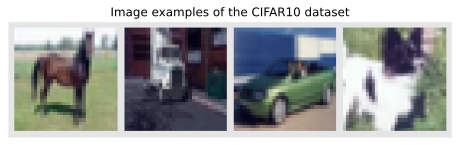

In [7]:
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
#train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=False)
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=False)


val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=False)
pl.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
pl.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=False)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

# Visualize some examples
NUM_IMAGES = 4
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [30]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

In [5]:
img_patches = img_to_patch(CIFAR_images, patch_size=16, flatten_channels=False)
print(img_patches.shape)


torch.Size([4, 4, 3, 16, 16])


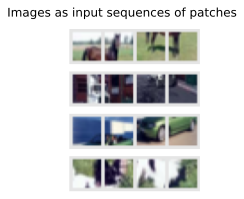

In [9]:
img_patches = img_to_patch(CIFAR_images, patch_size=16, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

In [2]:
class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )


    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [3]:
class VisionTransformer(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(25088, embed_dim)#num_channels*(patch_size**2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))


    def forward(self, x):
        # Preprocess input
        #print(x.shape)
        #x = img_to_patch(x, self.patch_size)
        print(x.shape)
        B, T, _ = x.shape
        x = self.input_layer(x)
        print(x.shape)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:,:T+1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [3]:
from approach_2.model import VisionTransformerEmbedded
from data_processing.cifar_100 import Cifar100
from data_processing.data_generator_approach_2 import DataGeneratorA2
from data_processing.transforms import *

hparams = {
    'batch_size': 8,
    'learning_rate': 1e-3,
    'epochs': 2,
    'loss_func': torch.nn.CrossEntropyLoss(),
    'optimizer': optim.AdamW
}

repo_root = os.path.abspath(os.getcwd())
model_root = os.path.join(repo_root, "trained_models/baselinemodel_batch1_lr0.001_epochs2_freezeFalse.model")
data_root = os.path.join(repo_root, "data")
seed = 69
split = 0.7
patch_size = 16
num_patches = int((32/patch_size)**2)
num_classes = 20

cnn_model = torch.load(model_root)
cnn_model = nn.Sequential(*(list(cnn_model.children())[:-2]))

#transforms = [RescaleTransform(), ReshapeToTensor(), Patches(patch_size=patch_size), Resize(), PassThroughCNN(cnn_model)]
#train = Cifar100(root=data_root, purpose='train', seed=seed, split=0.01, transform=transforms)
#val = Cifar100(root=data_root, purpose='val', seed=seed, split=0.999, transform=transforms)

#train_dataloader = DataGenerator(train, batch_size=hparams["batch_size"], flatten_batch=False)
#val_dataloader = DataGenerator(val, batch_size=hparams["batch_size"], flatten_batch=False)

#flattened_dim = train[0]['image'].flatten(2,3).flatten(1,2).shape[1]

model = VisionTransformerEmbedded(**{
                                    'embed_dim': 256,
                                    'hidden_dim': 512,
                                    'num_heads': 4,
                                    'num_layers': 2,
                                    'patch_size': patch_size,
                                    'num_patches': num_patches,
                                    'num_classes': num_classes,
                                    'dropout': 0.2,
                                    'hparams': hparams
                                })

transforms = [RescaleTransform(), ReshapeToTensor(), Patches(patch_size=patch_size), Resize()]
train = Cifar100(root=data_root, purpose='train', seed=seed, split=0.01, transform=transforms)
train_dataloader = DataGeneratorA2(train, batch_size=hparams["batch_size"], flatten_batch=True)
example_batch = next(iter(train_dataloader))

In [4]:
example_batch['image'].shape

torch.Size([8, 4, 3, 224, 224])

In [17]:
model.forward(example_batch['image'])

torch.Size([8, 4, 25088])


tensor([[-0.1239,  0.6080,  0.4810, -0.9196,  0.0951,  0.4431, -0.1232,  0.6270,
          0.9733,  0.4380,  0.1178,  0.7931, -0.2463,  0.9617, -0.2738,  0.0479,
          0.0344,  0.0556,  0.2116, -0.4123],
        [ 0.2670,  0.4166, -0.0569, -0.5194, -0.2674,  0.6511, -0.3128,  0.2205,
          0.6379,  0.0741,  0.6283,  0.9100, -0.2565,  0.2423,  0.3682, -0.4285,
          0.0810, -0.8589, -0.7361, -0.2017],
        [ 0.7476, -0.1263,  0.1062, -0.2366, -0.4078,  0.6016, -0.9271,  0.5132,
          0.9489,  0.2842,  0.3352,  0.5606, -0.4552,  0.7450,  0.1228, -0.0366,
         -0.0766, -0.9494, -0.5510, -0.2450],
        [ 0.3269,  0.6738, -0.3466, -0.4714, -0.5110, -0.6473,  0.2066,  0.3340,
          0.5496,  0.2127, -0.4758,  0.8881, -0.6043,  1.1477, -0.3702,  0.1421,
         -0.4535, -1.0706, -1.0205, -0.4539],
        [ 0.3806,  0.0191, -0.1610, -0.5925, -0.0962,  0.6264, -0.5514,  0.1910,
          1.0391,  0.3632,  0.6140,  0.6604,  0.0052,  0.3408, -0.7142, -0.6354,
      

In [8]:
from data_processing.cifar_100 import Cifar100
from data_processing.data_generator import DataGenerator
from data_processing.transforms import *
from approach_1.models import VisionTransformer
from approach_1.attention_training import AttentionSolver

hparams = {
    'batch_size': 8,
    'learning_rate': 1e-3,
    'epochs': 2,
    'loss_func': torch.nn.CrossEntropyLoss(),
    'optimizer': optim.AdamW
}

repo_root = os.path.abspath(os.getcwd())
model_root = os.path.join(repo_root, "trained_models/baselinemodel_batch1_lr0.001_epochs2_freezeFalse.model")
data_root = os.path.join(repo_root, "data")
seed = 69
split = 0.7
patch_size = 16
num_patches = int((32/patch_size)**2)
num_classes = 20

cnn_model = torch.load(model_root)
cnn_model = nn.Sequential(*(list(cnn_model.children())[:-2]))

transforms = [RescaleTransform(), ReshapeToTensor(), Patches(patch_size=patch_size), Resize(), PassThroughCNN(cnn_model)]
train = Cifar100(root=data_root, purpose='train', seed=seed, split=0.01, transform=transforms)
val = Cifar100(root=data_root, purpose='val', seed=seed, split=0.999, transform=transforms)

train_dataloader = DataGenerator(train, batch_size=hparams["batch_size"], flatten_batch=False)
val_dataloader = DataGenerator(val, batch_size=hparams["batch_size"], flatten_batch=False)

flattened_dim = train[0]['image'].flatten(2,3).flatten(1,2).shape[1]

model = VisionTransformer(**{
                                'embed_dim': 256,
                                'hidden_dim': 512,
                                #'num_heads': 8,
                                #'num_layers': 6,
                                'num_heads': 4,
                                'num_layers': 2,
                                'patch_size': patch_size,
                                'flattened_dim': flattened_dim,
                                'num_patches': num_patches,
                                'num_classes': num_classes,
                                'dropout': 0.2,
                                'hparams': hparams
                            })



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
patience = 3


solver = AttentionSolver(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    patience=patience
)

solver.train()

os.makedirs('trained_models', exist_ok=True)
models_path = os.path.join(repo_root, 'trained_models')
model.save(os.path.join(models_path, f'vitmodel_batch{hparams["batch_size"]}_lr{hparams["learning_rate"]}_epochs{hparams["epochs"]}.model'))


torch.Size([8, 4, 25088])
torch.Size([8, 4, 256])


KeyboardInterrupt: 

In [62]:
train[0]['label'].shape

(4,)

In [11]:
torch.save(model, os.path.join(models_path, f'vitmodel_batch{hparams["batch_size"]}_lr{hparams["learning_rate"]}_epochs{hparams["epochs"]}.model'))

In [33]:
(32/patch_size)**2

4.0

In [31]:
flattened_dim = train[0]['image'].flatten(2,3).flatten(1,2).shape[1]

In [6]:
train[0]['image'].shape

torch.Size([4, 512, 7, 7])

In [69]:
example_batch = next(iter(train_dataloader))

<class 'list'> 32 <class 'numpy.ndarray'>


In [70]:
example_batch['label'].shape

torch.Size([32])

In [33]:
model = VisionTransformer(**{
                                'embed_dim': 256,
                                'hidden_dim': 512,
                                'num_heads': 8,
                                'num_layers': 6,
                                'patch_size': 4,
                                'num_channels': 3,
                                'num_patches': 64,
                                'num_classes': 10,
                                'dropout': 0.2
                            })

In [7]:
from data_processing.cifar_100 import Cifar100
from data_processing.data_generator import DataGenerator
from data_processing.transforms import *
from approach_1.models import BaselineResNet
from approach_1.baseline_training import BaselineSolver

repo_root = os.path.abspath(os.getcwd())
model_root = os.path.join(repo_root, "trained_models/baselinemodel_batch1_lr0.001_epochs2_freezeFalse.model")
data_root = os.path.join(repo_root, "data")
cnn_model = torch.load(model_root)
cnn_model = nn.Sequential(*(list(cnn_model.children())[:-2]))

patch_size = 16
transforms = [RescaleTransform(), ReshapeToTensor(), Patches(patch_size=patch_size), Resize(), PassThroughCNN(cnn_model)]
train = Cifar100(root=data_root, purpose='train', seed=42, split=0.001, transform=transforms)
#example_image = torch.tensor(train[0]['image'], dtype=torch.float32)

In [15]:
example_batch = next(iter(train_dataloader))

<class 'list'> 4 <class 'numpy.ndarray'>


In [40]:
#example_img['image'].shape
torch.tensor(example_img['image'], dtype=torch.float32).shape

torch.Size([4, 3, 224, 224])

In [35]:
input_for_vit = train[0]['image'].unsqueeze(0)

In [36]:
input_for_vit.shape

torch.Size([1, 4, 512, 7, 7])

In [38]:
input_for_vit = input_for_vit.flatten(3,4).flatten(2,3)

In [47]:
input_for_vit.shape

torch.Size([1, 4, 25088])

In [ ]:
(4, 512, 7, 7)

batch_size=8

(8, 4, 512, 7, 7)

(8, 4, 512*7*7)

In [58]:
model.forward(example_batch['image']).shape

torch.Size([8, 20])

In [53]:

model

VisionTransformer(
  (input_layer): Linear(in_features=3, out_features=256, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): GELU()
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=512, out_features=256, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [9]:
class ViT(pl.LightningModule):

    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(f'{mode}_loss', loss)
        self.log(f'{mode}_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [10]:
def train_model(**kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "ViT"),
                         gpus=1 if str(device)=="cuda:0" else 0,
                         max_epochs=180,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")],
                         progress_bar_refresh_rate=1)
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ViT.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = ViT.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = ViT(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

In [11]:
model, results = train_model(model_kwargs={
                                'embed_dim': 256,
                                'hidden_dim': 512,
                                'num_heads': 8,
                                'num_layers': 6,
                                'patch_size': 4,
                                'num_channels': 3,
                                'num_patches': 64,
                                'num_classes': 10,
                                'dropout': 0.2
                            },
                            lr=3e-4)
print("ViT results", results)

C:\Users\HP\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Found pretrained model at saved_models\ViT.ckpt, loading...


C:\Users\HP\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:902: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
C:\Users\HP\anaconda3\lib\site-packages\torch\_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  if hasattr(mod, name):
<ipython-input-4-f00c84b03b46>:10: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)


Testing: 0it [00:00, ?it/s]

IndexError: Target 10 is out of bounds.

In [ ]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%tensorboard --logdir saved_models/tutorial15/tensorboards/